In [1]:
import sys; sys.path.append("../..")

import numpy as np
import torch
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem

from utils.data_utils import get_all_descriptors_from_smiles_list, get_scaffolds, DESCRIPTOR_NAMES

# Load Data

In [2]:
DATA_PATH = '../../datasets/gnns_vs_descriptors_jiang/dataset_used_for_modeling/hiv.csv'

data = pl.read_csv(source=DATA_PATH, columns=['cano_smiles', 'activity'])

data.head()

cano_smiles,activity
str,i64
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0
"""O=S(=O)(O)CCS(=O)(=O)O""",0


# Filter out Problematic SMILES

Had some problems with a few of the molecules. I investigated their structures manually and determined they were basically chemically impossible. Not sure why they are present, ideally would investigate original data source. However, for now, I am just removing them.

In [3]:
mols = [Chem.MolFromSmiles(smi) for smi in data['cano_smiles']]
len(mols)

40748

In [4]:
if 'mol_is_none' in data.columns:
    data = data.drop('mol_is_none')  
data.insert_column(index = 2, column=pl.Series(name='mol_is_none', values = [mol is None for mol in mols]))
data.head()

cano_smiles,activity,mol_is_none
str,i64,bool
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0,false
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0,false
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0,false
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0,false
"""O=S(=O)(O)CCS(=O)(=O)O""",0,false


In [5]:
mol_is_none_df = data.filter(pl.col('mol_is_none') == True)

mol_is_none_df

cano_smiles,activity,mol_is_none
str,i64,bool
"""CC(c1ccccn1)=[N+]1[N-]C(N)=[S+…",0,true
"""Cc1ccc([B-2]2(c3ccc(C)cc3)=NCC…",0,true
"""CC(c1cccs1)=[N+]1[N-]C(N)=[S+]…",0,true


In [6]:
for smi in mol_is_none_df['cano_smiles']:
    print(smi)

CC(c1ccccn1)=[N+]1[N-]C(N)=[S+][AlH3-]12[OH+]B(c1ccccc1)[OH+]2
Cc1ccc([B-2]2(c3ccc(C)cc3)=NCCO2)cc1
CC(c1cccs1)=[N+]1[N-]C(N)=[S+][AlH3-]12[OH+]B(c1ccccc1)[OH+]2


In [7]:
mol = Chem.MolFromSmiles('Cc1ccc([B]2(c3ccc(C)cc3)=NCCO2)cc1')
print(mol)

None


In [8]:
data = data.filter(pl.col('mol_is_none') == False)
data.shape

(40745, 3)

In [9]:
data = data.drop('mol_is_none')
data

cano_smiles,activity
str,i64
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0
"""O=S(=O)(O)CCS(=O)(=O)O""",0
…,…
"""CCc1nc2ccc(C(F)(F)F)cc2nc1O""",0
"""Cc1ccc(C(=O)N2CCCCC2)cc1N=NN(C…",0
"""O=[N+]([O-])c1ccc(Sc2c3ccccc3n…",0


In [10]:
# the ones that were removed. For safe keeping
mol_is_none_df

cano_smiles,activity,mol_is_none
str,i64,bool
"""CC(c1ccccn1)=[N+]1[N-]C(N)=[S+…",0,true
"""Cc1ccc([B-2]2(c3ccc(C)cc3)=NCC…",0,true
"""CC(c1cccs1)=[N+]1[N-]C(N)=[S+]…",0,true


# Analyze Data - Scaffolds

In [11]:
sns.set_style('darkgrid')

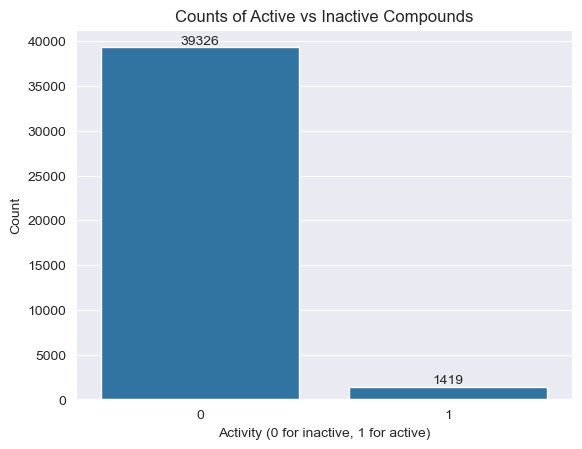

In [12]:
activity_counts = data['activity'].value_counts()

ax = sns.barplot(data = activity_counts, x = 'activity', y = 'count')
plt.xlabel('Activity (0 for inactive, 1 for active)')
plt.ylabel('Count')
plt.title('Counts of Active vs Inactive Compounds')

# add numbers to top of bars
for container in ax.containers:
    ax.bar_label(container)

In [13]:
scaffolds = get_scaffolds(data['cano_smiles'].to_list())

if 'scaffolds' in data.columns:
    data = data.drop('scaffolds')

data = data.with_columns(pl.Series(name='scaffold', values = scaffolds))

data.head()

cano_smiles,activity,scaffold
str,i64,str
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0,"""C1=[O+][Cu-3]2([O+]=CC1)[O+]=C…"
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0,"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…"
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0,"""c1ccc2c(c1)Nc1ccc3ccccc3c1S2"""
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0,"""C(=Cc1ccccc1)c1ccccc1"""
"""O=S(=O)(O)CCS(=O)(=O)O""",0,"""no_scaffold_0"""


In [14]:
# for the purposes of simplifying group splitting, I give molecules with no scaffold a scaffold of 'no_scaffold_{i}'. This way, they are recognized as separate groups
print(f'number of unique scaffolds: {len(set([sc for sc in scaffolds if not sc.startswith("no_scaffold_")]))}')
print(f'number of molecules with no scaffold: {len([sc for sc in scaffolds if sc.startswith("no_scaffold_")])}')

number of unique scaffolds: 18799
number of molecules with no scaffold: 1536


In [15]:
# safety check: do molecules with no scaffold have a unique scaffold name of 'no_scaffold_{i}'?
highest_no_scaffold_idx = max(list(map(lambda x: int(x.replace('no_scaffold_', '')), [sc for sc in scaffolds if sc.startswith("no_scaffold_")])))

assert len([sc for sc in scaffolds if sc.startswith("no_scaffold_")]) == highest_no_scaffold_idx + 1

In [16]:
most_common_scaffolds = data['scaffold'].value_counts(sort=True).head(25)

most_common_scaffolds

scaffold,count
str,u32
"""c1ccccc1""",2086
"""c1ccncc1""",165
"""C(=Cc1ccccc1)c1ccccc1""",162
"""O=c1ccn(C2CCCO2)c(=O)[nH]1""",162
"""O=C(C=Cc1ccccc1)c1ccccc1""",147
…,…
"""c1ccc(SSc2ccccc2)cc1""",68
"""C1CCCCC1""",68
"""O=C(Cc1cnc2ccccc2n1)C(=O)Nc1cc…",64


In [17]:
# within each unique scaffold, excluding molecules with no scaffold, what percentage are active?
percent_active_by_scaffold = data.group_by(pl.col('scaffold'))\
.agg(percent_active = pl.col('activity').mean(), count = pl.col('activity').count())\
.filter(pl.col('scaffold').str.contains('no_scaffold_') == False)

percent_active_by_scaffold.head()

scaffold,percent_active,count
str,f64,u32
"""c1ccc(CN2CC3CC4COC(C3)C42)cc1""",0.0,1
"""O=C1NC(=O)N2CCSC2N1""",0.0,2
"""c1ccc(CNN=C(c2ccccc2)c2ccccc2)…",0.0,1
"""c1cnn2c(c1)cc1ccnnc12""",0.0,1
"""C(=Cc1ccnc2ccccc12)c1ccc2c(c1)…",0.0,1


In [18]:
# making sure the number of molecules in this new grouped df + the number with no scaffolds equals the original number of molecules
assert percent_active_by_scaffold['count'].sum() + data.filter(pl.col('scaffold').str.contains('no_scaffold_') == True).shape[0] == data.shape[0]
# can you tell I'm paranoid?

In [19]:
# how many scaffolds are there that don't have the same activity? By design this would exclude scaffolds for which there is only one molecule
num_scaffolds_with_varying_activity = percent_active_by_scaffold.filter(pl.col('percent_active') < 1)\
.filter(pl.col('percent_active') > 0).shape[0]

print(f'number of scaffolds with varying activity: {num_scaffolds_with_varying_activity}')

number of scaffolds with varying activity: 366


In [20]:
num_molecules_with_scaffold_with_no_varying_activity = percent_active_by_scaffold.filter(pl.col('percent_active').is_in([0, 1]) == True)['count'].sum()

# how many could we predict correctly by just memorizing the scaffold? This can be a baseline. TBF this includes scaffolds with only one molecule and excludes molecules with no scaffold,
# so not perfect but something to consider
num_molecules_with_scaffold_with_no_varying_activity / data.shape[0]

0.801693459320162

Text(0.5, 1.0, 'Distribution of Activity within Scaffolds')

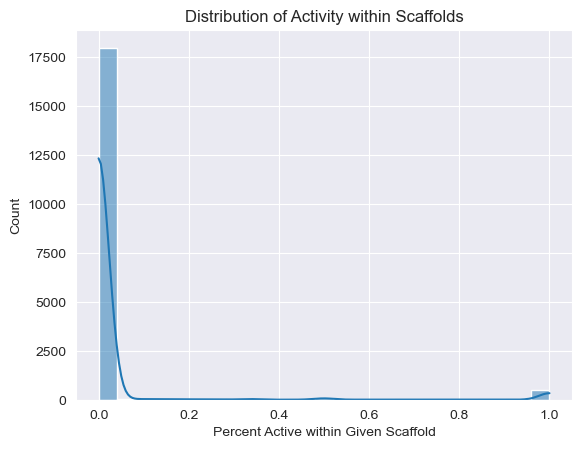

In [21]:
sns.histplot(percent_active_by_scaffold['percent_active'], kde=True, bins=25)
plt.xlabel('Percent Active within Given Scaffold')
plt.title('Distribution of Activity within Scaffolds')

Text(0.5, 1.0, 'Distribution of Activity within Scaffolds (excluding scaffolds with only one molecule)')

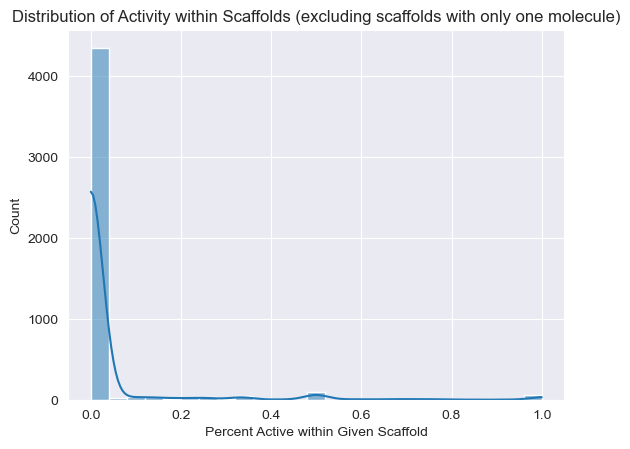

In [22]:
sns.histplot(percent_active_by_scaffold.filter(pl.col('count') > 1)['percent_active'], kde=True, bins=25)
plt.xlabel('Percent Active within Given Scaffold')
plt.title('Distribution of Activity within Scaffolds (excluding scaffolds with only one molecule)')

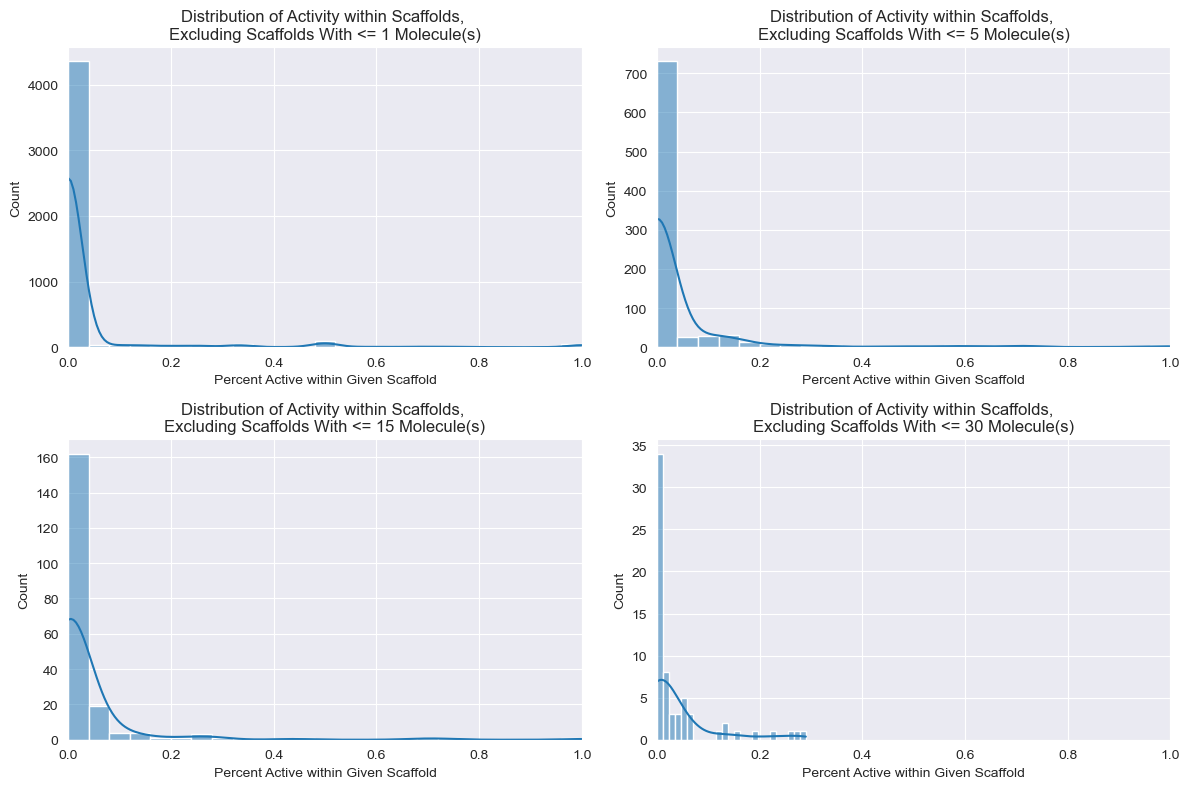

In [26]:
# investigating the distribution of activity within scaffolds with different count cutoff values
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

cutoffs = [1, 5, 15, 30]

for i in range(2):
    for j in range(2):
        this_ax = ax[i, j]
        cutoff = cutoffs[i * 2 + j]
        sns.histplot(percent_active_by_scaffold.filter(pl.col('count') > cutoff)['percent_active'], kde=True, bins=25, ax=this_ax)
        this_ax.set_xlabel('Percent Active within Given Scaffold')
        this_ax.set_title(f'Distribution of Activity within Scaffolds, \nExcluding Scaffolds With <= {cutoff} Molecule(s)')
        this_ax.set_xlim(0, 1)

# makes text not overlap
plt.tight_layout()

In [24]:
percent_active_by_scaffold['percent_active'].value_counts(sort=True, normalize=True)

percent_active,proportion
f64,f64
0.0,0.954732
1.0,0.025799
0.5,0.005266
0.333333,0.002553
0.25,0.001489
…,…
0.128205,0.000053
0.44,0.000053
0.6875,0.000053


Conclusion: in general there is little variance in the activity for any given scaffold. The problem is not nearly as bad for scaffolds with more corresponding molecules, but it's still pretty homogeneous. Therefore, a model could plausibly achieve good performance by just learning a lookup table of (scaffold, activity) pairs

# Analyze Data - Missing Values in  Molecular Descriptors

In [25]:
descriptors = get_all_descriptors_from_smiles_list(data['cano_smiles'].to_list(), as_polars=True)

Calculating descriptors: 100%|██████████| 40745/40745 [05:51<00:00, 115.82it/s]
/Users/christian_g/Projects/Chemical_Physics_and_KANs/notebooks/hiv/../../utils/data_utils.py:83: UserWarning: some descriptors are NaN, check input SMILES strings
  warnings.warn("some descriptors are NaN, check input SMILES strings")
/Users/christian_g/Projects/Chemical_Physics_and_KANs/notebooks/hiv/../../utils/data_utils.py:86: UserWarning: some descriptors are infinite, check input SMILES strings
  warnings.warn("some descriptors are infinite, check input SMILES strings")


In [55]:
descriptors_nan_mask = descriptors.select(pl.all().map_batches(lambda x: x.is_nan()))

Text(52.722222222222214, 0.5, 'Molecules')

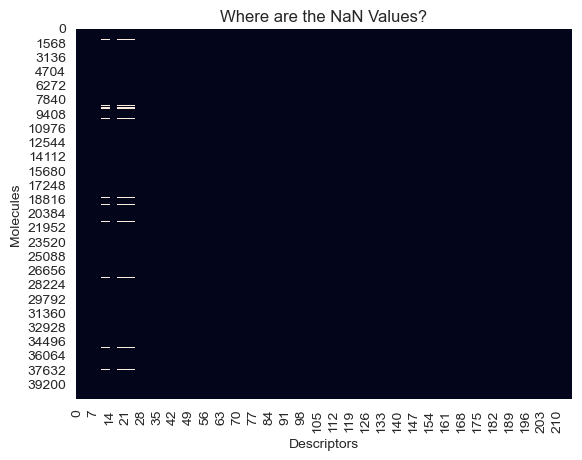

In [93]:
sns.heatmap(descriptors_nan_mask.to_numpy(), cbar=False)
plt.title('Where are the NaN Values?')
plt.xlabel('Descriptors')
plt.ylabel('Molecules')

In [129]:
# get the descriptors with >= 1 nan values
num_molecules = data.shape[0]

descriptors_with_nans_df = descriptors_nan_mask.sum()\
.transpose(include_header=True, header_name='descriptor', column_names=['nan_count'])\
.with_columns(percent_nan = pl.col('nan_count') / num_molecules)\
.filter(pl.col('nan_count') > 0)

descriptors_with_nans_df

descriptor,nan_count,percent_nan
str,u32,f64
"""MaxPartialCharge""",1301,0.03193
"""MinPartialCharge""",1301,0.03193
"""MaxAbsPartialCharge""",1301,0.03193
"""MinAbsPartialCharge""",1301,0.03193
"""BCUT2D_MWHI""",1387,0.034041
…,…,…
"""BCUT2D_CHGLO""",1387,0.034041
"""BCUT2D_LOGPHI""",1387,0.034041
"""BCUT2D_LOGPLOW""",1387,0.034041


In [141]:
# what does the distribution of percentages of nan values look like (will inform what imputation method to use)
descriptors_with_nans_df['percent_nan'].describe()

statistic,value
str,f64
"""count""",12.0
"""null_count""",0.0
"""mean""",0.033337
"""std""",0.001039
"""min""",0.03193
"""25%""",0.03193
"""50%""",0.034041
"""75%""",0.034041
"""max""",0.034041


In [130]:
descriptors_with_nans = descriptors_with_nans_df['descriptor'].to_list()
descriptors_with_nans

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

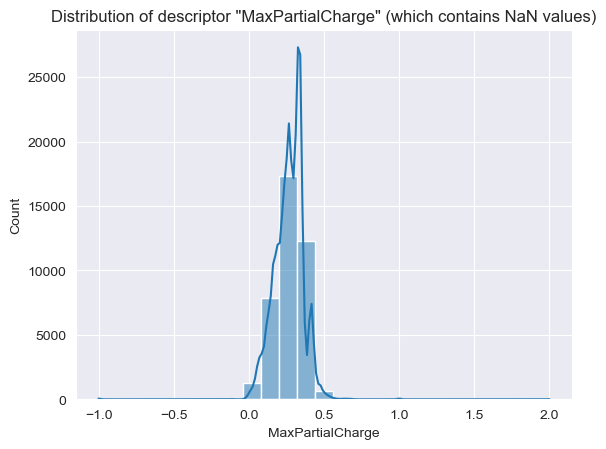

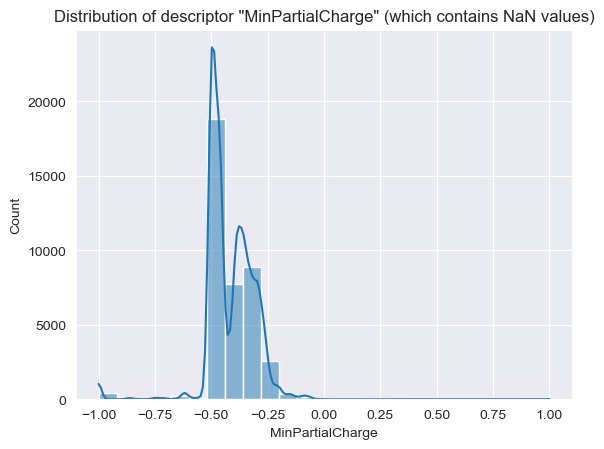

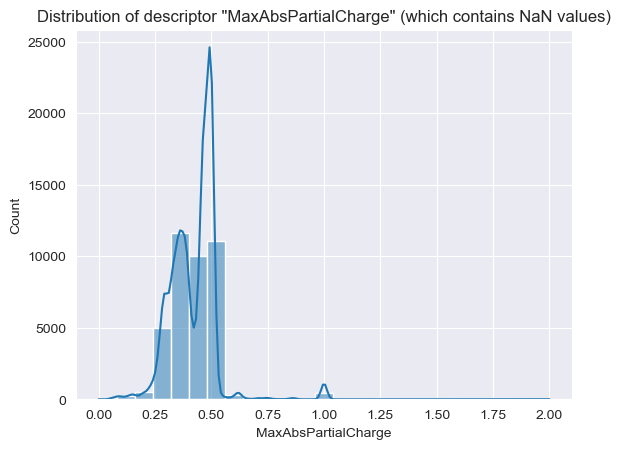

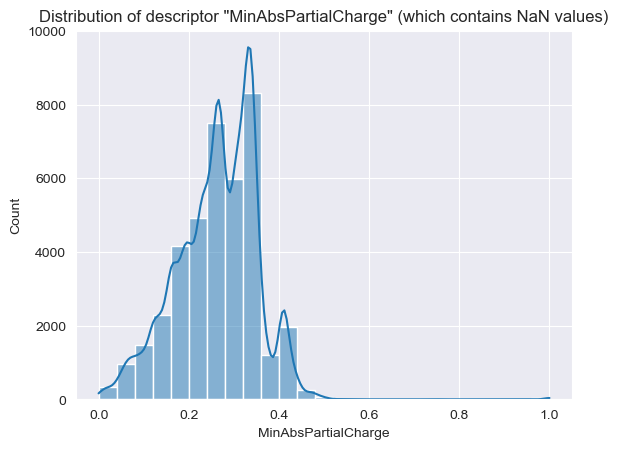

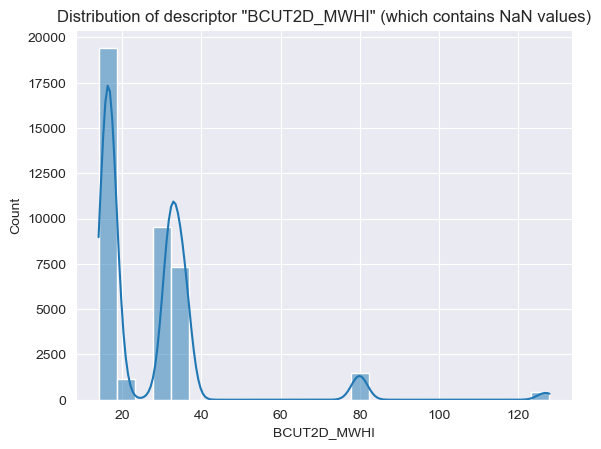

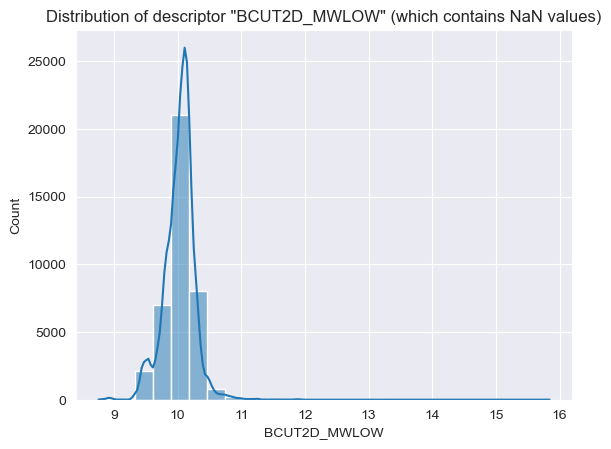

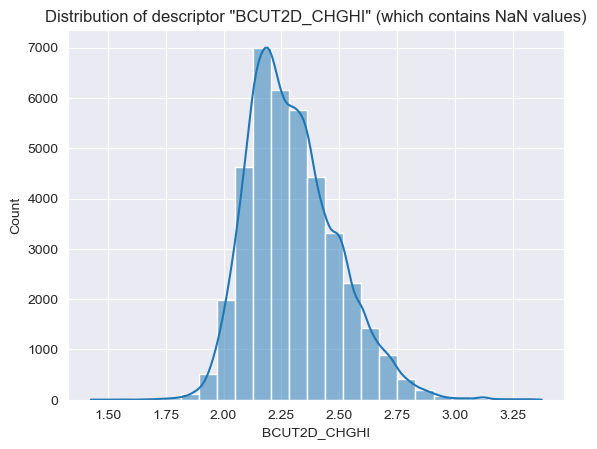

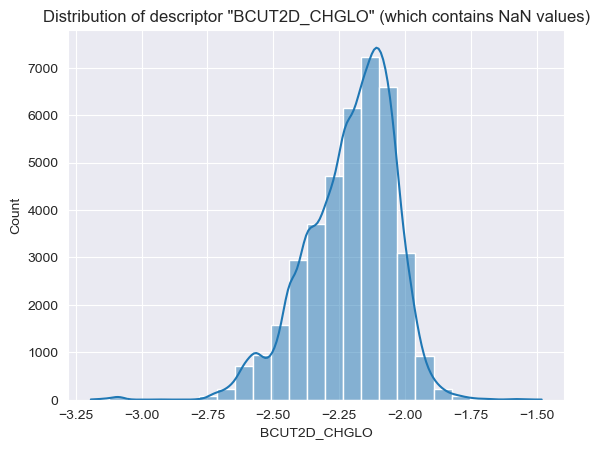

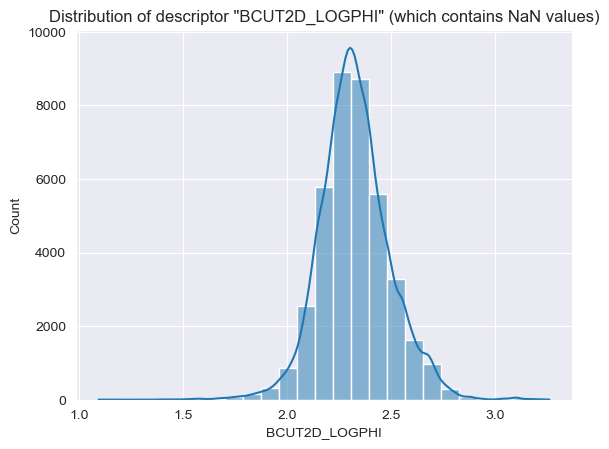

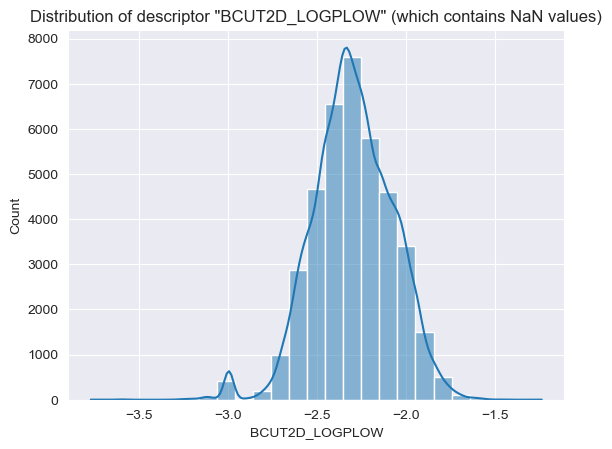

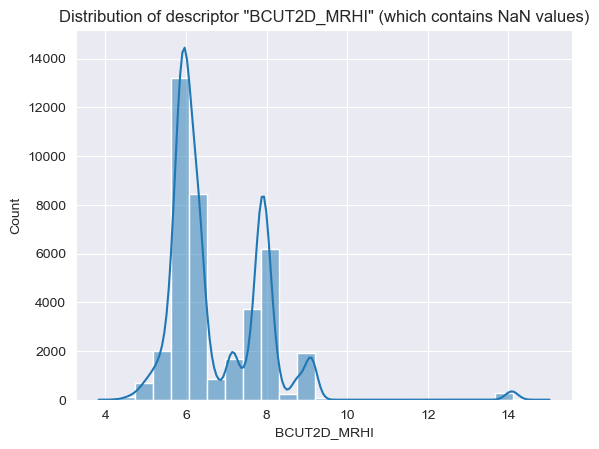

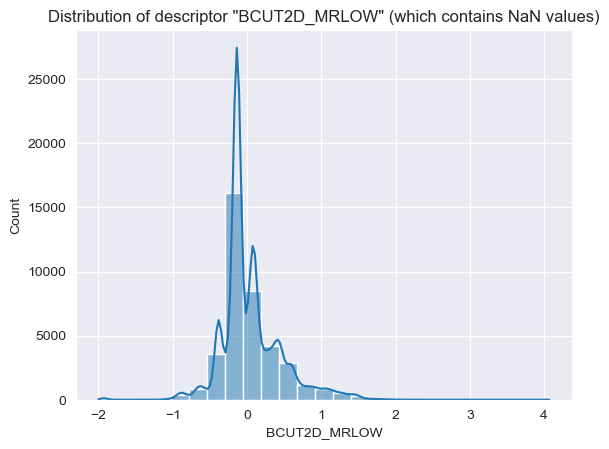

In [131]:
# check out the distributions of features with missing values. Mainly to know if I should consider imputing mean or median
for col in descriptors.select(pl.col(descriptors_with_nans)).iter_columns():
    sns.histplot(col, bins=25, kde=True)
    plt.title(f'Distribution of descriptor "{col.name}" (which contains NaN values)')
    plt.xlabel(col.name)
    plt.show()

Ok well these distributions look gross so I'm just gonna use median.

Text(52.722222222222214, 0.5, 'Molecules')

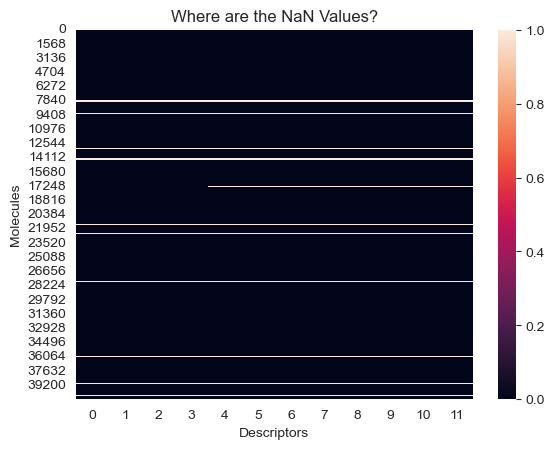

In [132]:
# same plot of where NaNs are but with only the descriptors with NaNs
sns.heatmap(descriptors.select(pl.col(descriptors_with_nans).map_batches(lambda x: x.is_nan())))
plt.title('Where are the NaN Values?')
plt.xlabel('Descriptors')
plt.ylabel('Molecules')

In [133]:
data_with_nan_descriptors = pl.concat([data, descriptors.select(pl.col(descriptors_with_nans))], how='horizontal')
data_with_nan_descriptors.head()

cano_smiles,activity,scaffold,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW
str,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0,"""C1=[O+][Cu-3]2([O+]=CC1)[O+]=C…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0,"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0,"""c1ccc2c(c1)Nc1ccc3ccccc3c1S2""",0.227991,-0.278994,0.278994,0.227991,32.166581,10.085465,2.265088,-2.305509,2.500915,-2.252105,7.995965,-0.115439
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0,"""C(=Cc1ccccc1)c1ccccc1""",0.29469,-0.398692,0.398692,0.29469,32.241217,10.114378,2.161662,-2.06079,2.2416,-2.02834,7.857715,0.480421
"""O=S(=O)(O)CCS(=O)(=O)O""",0,"""no_scaffold_0""",0.265456,-0.285515,0.285515,0.265456,32.243582,10.962804,2.109469,-1.917374,1.864461,-2.147724,7.891386,0.471615


In [134]:
# add a column that is True if at least one of the descriptor values is NaN for each sample
data_with_nan_descriptors = data_with_nan_descriptors.with_columns(at_least_one_nan_descriptor=pl.any_horizontal(pl.col(descriptors_with_nans).is_nan()))

data_with_nan_descriptors.head()

cano_smiles,activity,scaffold,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,at_least_one_nan_descriptor
str,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0,"""C1=[O+][Cu-3]2([O+]=CC1)[O+]=C…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0,"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0,"""c1ccc2c(c1)Nc1ccc3ccccc3c1S2""",0.227991,-0.278994,0.278994,0.227991,32.166581,10.085465,2.265088,-2.305509,2.500915,-2.252105,7.995965,-0.115439,false
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0,"""C(=Cc1ccccc1)c1ccccc1""",0.29469,-0.398692,0.398692,0.29469,32.241217,10.114378,2.161662,-2.06079,2.2416,-2.02834,7.857715,0.480421,false
"""O=S(=O)(O)CCS(=O)(=O)O""",0,"""no_scaffold_0""",0.265456,-0.285515,0.285515,0.265456,32.243582,10.962804,2.109469,-1.917374,1.864461,-2.147724,7.891386,0.471615,false


In [135]:
data_with_nan_descriptors['at_least_one_nan_descriptor'].value_counts()

at_least_one_nan_descriptor,count
bool,u32
true,1387
false,39358


In [136]:
# any significant differences in activity? Aka is it missing at random?
data_with_nan_descriptors.group_by(pl.col('at_least_one_nan_descriptor'))\
.agg(percent_active=pl.col('activity').mean(), num_active=pl.col('activity').sum(), num_inactive=pl.col('activity').count() - pl.col('activity').sum())

at_least_one_nan_descriptor,percent_active,num_active,num_inactive
bool,f64,i64,i64
false,0.031582,1243,38115
true,0.126893,176,1211


Not gonna do a stats test here but the conclusion is that there is a clear difference in the activity for samples with missing descriptors. Therefore, we shouldn't drop those samples because the features are not missing at random and it would create bias in our data.

In [137]:
# get the molecules with at least one NaN descriptor value
data_with_samples_with_nan_descriptors = data_with_nan_descriptors.filter(pl.any_horizontal(pl.col(descriptors_with_nans).is_nan()) == True)
data_with_samples_with_nan_descriptors.shape

(1387, 16)

In [138]:
data_with_samples_with_nan_descriptors['scaffold'].value_counts(sort=True)

scaffold,count
str,u32
"""c1ccccc1""",77
"""c1ccc(P(c2ccccc2)c2ccccc2)cc1""",45
"""c1ccc(C[PH](c2ccccc2)(c2ccccc2…",35
"""C(=Cc1ccccc1)[Se]c1ccccc1""",17
"""O=C(O[Sn]O[Sn]OC(=O)c1ccccc1)c…",12
…,…
"""C1=[O+][Zn-2]2([O+]=Cc3ccccc3[…",1
"""O=C1CCNC(CC=CP2(=O)NCC(c3ccccc…",1
"""O=C1C=CC(=O)c2cc3c(cc21)C(=O)C…",1


For now, I'm going to impute the median (later, not right now so I don't leak data). However, I would like to eventually use some variant of Multivariate Imputation by Chained Equations

paper on this subject: https://www.sciencedirect.com/science/article/pii/S0957417424005207

sklearn's weird implementation: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer

...they explain the difference from MICE here: https://scikit-learn.org/stable/modules/impute.html

statsmodel's implementation: https://www.statsmodels.org/stable/imputation.html 

# Prepare Data for Modeling

In [143]:
OPTIONS = {
    'test_size': 0.2,
    'random_seed': 1738,
}

In [175]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report

In [148]:
data_full = pl.concat([data, descriptors], how='horizontal')

data_full.head()

cano_smiles,activity,scaffold,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,…,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
str,i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CCC1=[O+][Cu-3]2([O+]=C(CC)C1)…",0,"""C1=[O+][Cu-3]2([O+]=CC1)[O+]=C…",5.925903,5.925903,0.759994,-2.330012,0.434358,23.368421,319.888,295.696,319.096508,114.0,0.0,NaN,NaN,NaN,NaN,0.631579,0.894737,1.105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.451928,2.470867,386.327861,13.880469,12.177145,13.118797,9.14162,6.965717,…,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",0,"""C(=Cc1ccccc1)C1=[O+][Cu-3]2([O…",6.515117,6.515117,0.475558,-2.879653,0.104103,20.717949,564.14,535.916,563.127808,198.0,0.0,NaN,NaN,NaN,NaN,0.410256,0.769231,1.153846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.004249,1.474572,1493.142859,26.332006,21.205125,22.146776,19.245846,12.687178,…,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""CC(=O)N1c2ccccc2Sc2c1ccc1ccccc…",0,"""c1ccc2c(c1)Nc1ccc3ccccc3c1S2""",12.177015,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,278.271,291.071785,102.0,0.0,0.227991,-0.278994,0.278994,0.227991,0.904762,1.666667,2.52381,32.166581,10.085465,2.265088,-2.305509,2.500915,-2.252105,7.995965,-0.115439,2.51855,2.051191,871.976255,14.396977,11.537213,12.353709,10.25402,6.848577,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)…",0,"""C(=Cc1ccccc1)c1ccccc1""",11.401803,11.401803,0.08779,-4.524487,0.357615,12.583333,370.408,356.296,370.029328,128.0,0.0,0.29469,-0.398692,0.398692,0.29469,0.708333,1.041667,1.333333,32.241217,10.114378,2.161662,-2.06079,2.2416,-2.02834,7.857715,0.480421,2.446346,2.586774,943.72535,18.120956,12.11742,13.750413,10.9812,6.404165,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""O=S(=O)(O)CCS(=O)(=O)O""",0,"""no_scaffold_0""",9.857917,9.857917,0.980324,-4.296481,0.538723,13.4,190.198,184.15,189.96058,62.0,0.0,0.265456,-0.285515,0.285515,0.265456,0.8,1.0,1.1,32.243582,10.962804,2.109469,-1.917374,1.864461,-2.147724,7.891386,0.471615,1.573012,4.047792,249.709506,8.414214,4.75813,6.391124,4.207107,2.109165,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
data_full.shape

(40745, 220)

In [195]:
X = data_full[DESCRIPTOR_NAMES].to_numpy()

y = data_full['activity']

X.shape, y.shape

((40745, 217), (40745,))

In [196]:
splitter = GroupShuffleSplit(n_splits=1, test_size=OPTIONS['test_size'], random_state=OPTIONS['random_seed'])

train_idx, test_idx = next(splitter.split(X=X, y=y, groups=data_full['scaffold']))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33507, 217), (7238, 217), (33507,), (7238,))

In [197]:
# the group split won't actually produce the desired test size since it has to keep groups together
actual_test_size = X_test.shape[0] / X.shape[0]

print(f'intended test size: {OPTIONS['test_size']} \nactual test size: {actual_test_size}')

intended test size: 0.2 
actual test size: 0.17764142839612224


In [232]:
# impute the median
train_medians = np.nanmedian(X_train, axis=0)

print(f'Imputing {np.isnan(X_train).sum()} NaN/Inf values in the training set with the median of the training set...')

X_train_imputed = np.nan_to_num(X_train, nan=train_medians, neginf=train_medians, posinf=train_medians)

assert np.isnan(X_train_imputed).sum() == 0

print('Done.')

print(f'Imputing {np.isnan(X_test).sum()} NaN/Inf values in the test set with the median of the training set...')

X_test_imputed = np.nan_to_num(X_test, nan=train_medians, neginf=train_medians, posinf=train_medians)

assert np.isnan(X_test_imputed).sum() == 0

print('Done.')

X_train_imputed.shape, X_test_imputed.shape

Imputing 13848 NaN/Inf values in the training set with the median of the training set...
Done.
Imputing 2452 NaN/Inf values in the test set with the median of the training set...
Done.


((33507, 217), (7238, 217))

I don't know the best approach for handling inf values. Should you impute the max or min? There's no way the median is the right approach here

# Trying to Fit A Random Forest as a Baseline

In [234]:
from sklearn.ensemble import RandomForestClassifier

In [235]:
model = RandomForestClassifier(random_state=OPTIONS['random_seed'])

model.fit(X_train_imputed, y_train)

y_pred = model.predict(X_test_imputed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6923
           1       0.71      0.13      0.22       315

    accuracy                           0.96      7238
   macro avg       0.84      0.56      0.60      7238
weighted avg       0.95      0.96      0.95      7238



# Train Model

# Analyze Model Performance